# Метод обратного распространения ошибки для классификации рукописных цифр из набора данных MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Загрузка данных

In [2]:
def loader():

    # Загружаем данные из https://www.openml.org/d/554
    X, y = fetch_openml('mnist_784', return_X_y = True, as_frame = False)
    N = X.shape
    y = y.astype('int8')
    return X,y

## Разбиение данных на тренировочную и тестовую выборки

In [3]:
def split(X,y):
    N_test = 10000
    N_train = X.shape[0] - N_test
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = N_train, test_size = N_test, 
                                                    stratify = y, random_state = 42)
    X_train.shape, X_test.shape
    return X_train, X_test, y_train, y_test

In [4]:
X,y = loader()
X_train, X_test, y_train, y_test=split(X,y)

## Демонстрация некоторых изображений из тестовой выборки

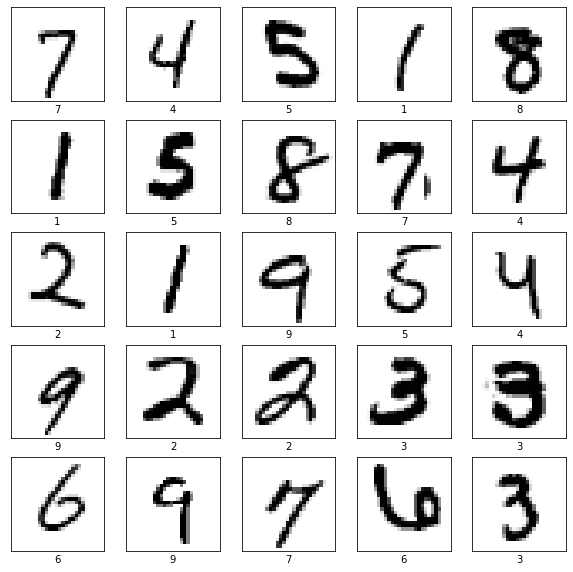

In [5]:
plt.figure(figsize=(10,10))
i = 0
for i in range(25):
  image = np.reshape(X_test[i, :], (28, 28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(y_test[i])
  i += 1
plt.show()

Значение каждого пикселя в изображении находится в интервале [0,255]. Для того, чтобы модель работала корректно эти значения необходимо нормализовать — привести к значениям в интервале [0,1]. Поэтому чуть ниже мы объявляем и реализуем функцию нормализации, а затем применяем её к каждому изображению в тренировочных и тестовых наборах данных.

In [6]:
def normalization(X_train,X_test,n):
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train = X_train/n
    X_test = X_test/n
    return(X_train, X_test)       
    

In [7]:
def one_hot_ercoding(y_train,y_test):
    y_train = np.eye(10)[y_train] # convert to one-hot
    y_test = np.eye(10)[y_test] # convert to one-hot
    return y_train, y_test

In [8]:
X_train, X_test = normalization(X_train,X_test,255)
y_train,y_test = one_hot_ercoding(y_train,y_test)

## Определение функций активации и функции ошибки

<ul>В качестве функции активации на скрытом слое используется функция ReLU: </ul>
    $$\phi(x) = max(0,x)$$ 
<ul>В качестве функции активации на выходном слое используется функция softmax: </ul>
    $$f(y_i) = \frac{e^u_i}{\sum_{j = 1}^{N}e^u_i}$$
<ul>В качестве функции ошибки используется кросс-энтропия:</ul>
$$E=-\sum_{j=1}^{n}y_jlog(u_j)$$
где <ul>$y_j$ - истинная метка (нейрона j), </ul>
   <ul> $u_i$ - выход нейрона j, полученый прямым проходом</ul>
   <ul> $N$ - число классов</ul>


In [9]:
def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    exp = np.exp(x)
    return exp/np.sum(exp, axis = 1, keepdims = True)

def cross_entropy_loss(x, y):
    return np.mean(-np.sum(x * np.log(y), axis=1))

В пакетном режиме корректировка весов осуществляется по всем примерам эпохи. Функция ошибки нормирована по числу примеров выборки

## Построение двухслойной полностью связной сети

Рассмотрим двухслойную нейронную сеть

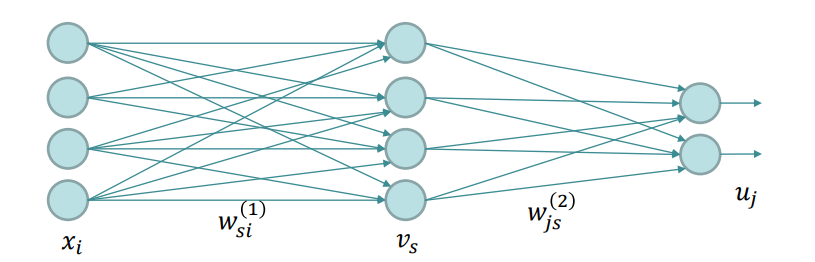

### Прямой проход
0. Инициализация синаптических весов сети
1. Суммирование cигналов на скрытом слое $z_1= b_{0s} +\sum_{i=0}^{N}w_{si} x_i$ , где $z_1$- взвешанная сумма нейронов скрытого слоя, N - число классов
2. Применение функции активации ReLu $v_s = \phi(z_1)$
3. Для каждого выходного нейрона суммируются взвешенные входящие сигналы  $z_2= b_{0j} +\sum_{s=0}^{K}w_{js}v_s$, где K- количество нейронов на скрытом слое
4. Применяем функцию активации softmax на выходном слое  $u_j = f(z_2)$


### Обратный проход
1. Производная функции ошибки по параметрам последнего слоя:

$$\frac{\partial{E}}{\partial{w_{js}}} = (u_j - y_j)v_s $$

2. Производная функции ошибки по параметрам скрытого слоя:

$$\frac{\partial{E}}{\partial{w_{si}}}= (u_j - y_j)w_{js} \frac{d\phi(z_1)}{d(z_1)} x_i$$

3. Корректировка синаптических весов

$$w(k+1) = w(k)-learningRate▿E(w(k))$$



In [10]:
class Net(object):
    def __init__(self, num_nodes_in_layers):
        # инициализация синаптических весов сети из нормалльного распределения
        self.w1 = np.random.normal(0, np.sqrt(2 / num_nodes_in_layers[0]), [num_nodes_in_layers[0], num_nodes_in_layers[1]])
        self.w2 = np.random.normal(0, np.sqrt(2 / num_nodes_in_layers[1]), [num_nodes_in_layers[1], num_nodes_in_layers[2]])

        # определение смещений
        self.b1 = np.zeros((1, num_nodes_in_layers[1]))
        self.b2 = np.zeros((1, num_nodes_in_layers[2]))
        
    #вычисление значений выходных сигналов нейронов всех слоев
    def forward(self, x):
        self.z1 = x@self.w1 + self.b1
        self.v = relu(self.z1)
        self.z2 = self.v@self.w2 + self.b2
        self.u = softmax(self.z2)

    def backpropagation(self, x_train, y_train, learningRate):
        dz2 = (self.u - y_train) / self.u.shape[0] # batch_size x output
        dw1 = self.v.T@dz2 #(hidden x batch_size) * (batch_size x output)
        db1 = np.sum(dz2, axis=0, keepdims=True)# суммирование по столбцам, размер сохраняется 1 x output
        
        dz1 = dz2 @self.w2.T * np.where(self.z1 > 0.0, 1, 0) #(batch_size x output)*(output x hidden)
        dw0 = x_train.T @ dz1
        db0 = np.sum(dz1, axis=0, keepdims=True)# суммирование по столбцам, размер сохраняется 1 x output
        
        # изменение весов
        self.w2 -= learningRate * dw1
        self.w1 -= learningRate * dw0
        
        # изменение смещений
        self.b2 -= learningRate * db1
        self.b1 -= learningRate * db0


    def train(self, x_train, y_train, epochs=20, learning_rate=0.1, batch_size=64):
        train_time = 0
        for epoch in range(epochs):
            i = 0
            start = timer()
            while i < len(x_train):
                x_batch = x_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                self.forward(x_batch)
                self.backpropagation(x_batch, y_batch, learning_rate)
                i += batch_size
            self.forward(x_train)
            cross_entropy = cross_entropy_loss(y_train, self.u)
            accuracy = np.mean(np.argmax(y_train, axis=1) == np.argmax(self.u, axis=1))
            finish = timer()
            train_time += finish - start
            print('Epoch: {}\t Loss: {:.4f} \t Accuracy: {:.4f} \t Time: {:.3f}'.format(epoch + 1, cross_entropy, accuracy,finish - start ))      
        print("Train loss: {:.3f}\nTrain accuracy: {:.3f}".format(cross_entropy, accuracy))
        print('Train time = {:.5f} s'.format(train_time))
        


    def test(self, x_test, y_test):
        out = self.forward(x_test)
        cross_entropy = cross_entropy_loss(y_test, self.u)
        accuracy = np.mean(np.argmax(y_test, axis=1) == np.argmax(self.u, axis=1))

        print()
        print("Test loss: {:.3f}\nTest accuracy: {:.3f} ".format(cross_entropy, accuracy))
        

## Обучение и тестирование построенной модели

In [11]:
input_layer_size = 28*28
hidden_layer_size = 300
batch_size=64
model = Net([input_layer_size, hidden_layer_size, 10])# количество нейронов во входном,скрытом и выходном слоях
model.train(X_train, y_train, epochs=20, learning_rate=0.1, batch_size = batch_size)
model.test(X_test, y_test)

Epoch: 1	 Loss: 0.2152 	 Accuracy: 0.9401 	 Time: 4.097
Epoch: 2	 Loss: 0.1479 	 Accuracy: 0.9586 	 Time: 3.854
Epoch: 3	 Loss: 0.1125 	 Accuracy: 0.9691 	 Time: 3.810
Epoch: 4	 Loss: 0.0908 	 Accuracy: 0.9749 	 Time: 3.815
Epoch: 5	 Loss: 0.0759 	 Accuracy: 0.9789 	 Time: 3.824
Epoch: 6	 Loss: 0.0649 	 Accuracy: 0.9823 	 Time: 3.863
Epoch: 7	 Loss: 0.0565 	 Accuracy: 0.9849 	 Time: 3.844
Epoch: 8	 Loss: 0.0498 	 Accuracy: 0.9873 	 Time: 4.571
Epoch: 9	 Loss: 0.0441 	 Accuracy: 0.9889 	 Time: 3.784
Epoch: 10	 Loss: 0.0396 	 Accuracy: 0.9902 	 Time: 3.809
Epoch: 11	 Loss: 0.0356 	 Accuracy: 0.9914 	 Time: 3.783
Epoch: 12	 Loss: 0.0322 	 Accuracy: 0.9925 	 Time: 3.785
Epoch: 13	 Loss: 0.0292 	 Accuracy: 0.9934 	 Time: 3.785
Epoch: 14	 Loss: 0.0267 	 Accuracy: 0.9943 	 Time: 3.808
Epoch: 15	 Loss: 0.0244 	 Accuracy: 0.9952 	 Time: 3.777
Epoch: 16	 Loss: 0.0223 	 Accuracy: 0.9958 	 Time: 3.985
Epoch: 17	 Loss: 0.0205 	 Accuracy: 0.9964 	 Time: 3.871
Epoch: 18	 Loss: 0.0189 	 Accuracy: 0.99

## Использование инструмента PyTorch для классификации рукописных цифр набора MNIST

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import torch.nn as nn

## Загрузка данных

In [13]:
batch_size = 64
train_dataset = torchvision.datasets.MNIST(root = os.getcwd(), train = True,
download = True, transform = torchvision.transforms.ToTensor())

test_dataset = torchvision.datasets.MNIST(root = os.getcwd(), train = False,
download = True, transform = torchvision.transforms.ToTensor())

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## Построение двухслойной полностью связной сети

In [14]:
class Net_Torch(nn.Module):
    def __init__(self,input_layer_size, hidden_layer_size, count_class):
        super(Net_Torch, self).__init__()
        self.linear1 = nn.Linear(input_layer_size, hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size, count_class)
     # Переопределение метода, вызываемого в процессе прямого прохода
    def forward(self, x):
        out = self.linear1(x)
        out = torch.nn.functional.relu(out)
        out = self.linear2(out)
        out = torch.nn.functional.softmax(out)
        return out

## Обучение построенной модели

In [15]:
# Функция вычисления точности top-1
def get_accuracy(data_loader, model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader: 
            images = images.view(-1, image_resolution).requires_grad_().to(device)
            labels = labels.to(device)
            outputs = model(images)
            # Выбор предсказанных меток с максимальной достоверностью.
            # outputs.data - объект типа torch.tensor, двумерный тензор, массив
            # векторов достоверности принадлежности каждому из 10 допустимых классов
            # (размерность 0 - номер изображения в пачке, размерность 1 - номер класса);
            # predicted - объект типа torch.tensor (одномерный тензор меток классов).
            # Выбор максимальных значений выполняется по первой размерности
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0) # количество изображений, совпадает с batch_size
            tp += (predicted == labels).sum() # определение количества корректных совпадений
    return tp / n


def train_torch(nn_model_torch, train_data_loader, num_epochs, learning_rate):
    # Выбор устройства для вычислений
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    nn_model_torch.to(device)

    # Функция ошибки на этапе обучения
    loss_function = torch.nn.CrossEntropyLoss()

    # Метод оптимизации для обучения параметров
    optimizer = torch.optim.SGD(nn_model_torch.to(device).parameters(), lr = learning_rate)
    train_time = 0
    for epoch in range(num_epochs):  # проход по эпохам
        start = timer()
        for i, (images, labels) in enumerate(train_data_loader): # получение пачки тренировочных данных
            # Преобразование тензора [B, C, W, H] к формату [B, W * H]
            # (images.shape=[B, C, W, H], B - размер пачки, C=1 - число каналов
            # W, H - ширина и высота изображений в пачке) и загрузка данных на устройство
            images = images.view(-1, image_resolution).requires_grad_().to(device)
            labels = labels.to(device)
            # Прямой проход
            outputs = nn_model_torch(images) # вычисление выхода сети
            loss = loss_function(outputs, labels) # вычисление функции ошибки, loss.item() дает значение
            # Обратный проход
            optimizer.zero_grad() # обнуление всех вычисляемых градиентов
            loss.backward() # вычисление градиента функции ошибки
            optimizer.step() # обновление параметров модели
        finish = timer()
        # Логирование метрики качества на тренировочных данных по завершении эпохи
        print('Epoch[{}]: accuracy = {:.5f} time: {:.5f}'.
              format(epoch, get_accuracy(train_data_loader, nn_model_torch), finish - start))
        train_time += finish - start
    print('Train time = {:.5f} s'.format(train_time))

In [16]:
# Обучение построенной модели
nn_model_torch = Net_Torch(input_layer_size,hidden_layer_size, 10)
batch_size=64
learning_rate = 0.1
num_epochs = 20 
image_resolution = 28 * 28
train_torch(nn_model_torch,train_data_loader, num_epochs,learning_rate) 
print('Параметры обучения:\n1. Количество эпох = {}\n2. Оптимизатор = {}\n3. Скорость обучения = {}\n4. Размер партии данных {}'.format(num_epochs, "SGD", learning_rate, batch_size))

Epoch[0]: accuracy = 0.82633 time: 9.34397
Epoch[1]: accuracy = 0.83982 time: 10.93755
Epoch[2]: accuracy = 0.84660 time: 10.69632
Epoch[3]: accuracy = 0.90912 time: 11.19161
Epoch[4]: accuracy = 0.92092 time: 10.39991
Epoch[5]: accuracy = 0.92643 time: 10.41390
Epoch[6]: accuracy = 0.93275 time: 10.50660
Epoch[7]: accuracy = 0.93613 time: 10.62975
Epoch[8]: accuracy = 0.94003 time: 10.85603
Epoch[9]: accuracy = 0.94322 time: 11.06151
Epoch[10]: accuracy = 0.94495 time: 10.66036
Epoch[11]: accuracy = 0.94747 time: 11.36024
Epoch[12]: accuracy = 0.94998 time: 10.67951
Epoch[13]: accuracy = 0.95218 time: 10.86565
Epoch[14]: accuracy = 0.95412 time: 10.67998
Epoch[15]: accuracy = 0.95633 time: 10.43626
Epoch[16]: accuracy = 0.95770 time: 10.86765
Epoch[17]: accuracy = 0.95940 time: 11.72015
Epoch[18]: accuracy = 0.96070 time: 10.86829
Epoch[19]: accuracy = 0.96202 time: 10.70781
Train time = 214.88306 s
Параметры обучения:
1. Количество эпох = 20
2. Оптимизатор = SGD
3. Скорость обучения 

## Тестирование обученной модели

In [17]:
print('Test accuracy: {:.5f}'.format(get_accuracy(test_data_loader, nn_model_torch)))

Test accuracy: 0.95460


## Результаты работы на контрольном наборе параметров

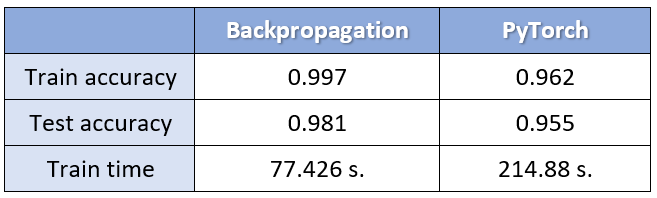